# Gamma-ray propagation analysis

Here we analyse the simulations of gamma-ray propagation for the two scenarios, with and without LIV.

In [29]:
using Corpuscles
using CSV
using DataFrames
using CairoMakie
using StatsBase

In [30]:
"""
Reads a simulation file and returns a DataFrame with the data.
"""
function readSimulation(filename)	
	columns = ["D", "ID", "E", "ID0", "E0", "W"]
	data = CSV.File(filename; header = columns, comment = "#") |> DataFrame
	return data
end



readSimulation

Now we proceed with the postprocessing of the simulation. 
We simulated events following a distribution
\begin{equation}
	\dfrac{\text{d}N}{\text{d}E_0} \propto E_0^{-1}	\,.
\end{equation}

Suppose we actually wanted to have events distributed according to some spectrum:
\begin{equation}
	\dfrac{\text{d}N}{\text{d}E_0} \propto E_0^{-\alpha} \exp\left( - \dfrac{E}{E_{\text{max}}}\right)	\,.
\end{equation}

The reweighting procedure for this change is implemented in the function below.

In [31]:
"""
Given a dataframe with the simulation, this function computes the desired weights.
These weights are saved in the dataframe as a new column with a name of choice (here `W1`).
The simulation is assumed to have a spectrum E^(-α0), with α0=1 in this case.

# Input
. `data`: dataframe containing the simulations \\
. `α`: desired spectral index \\
. `Emax`: spectrum cuts off above Emax \\
. `columnName`: name of the column to be created; defaults to 'W1' \\
. `α0`: injection spectrum used in the simulation (default to α0 = 1) \\
"""
function reweightSimulation!(data, α, Emax; columnName = "W1", α0 = 1.)
	# define the function for reweighting the spectrum
	weightSpectrum(E) = E ^ (α0 - α) * exp(- E / (Emax))

	# other functions can be defined here, e.g. for the distance weight
	# weightDistance = ....

	data[!, columnName] = weightSpectrum.(data.E0)
end

reweightSimulation!

In [32]:
filenameSR = "simulations/sim1D-gamma-SR.txt"
filenameLIV2m = "simulations/sim1D-gamma-LIV1_m.txt"
filenameLIV2p = "simulations/sim1D-gamma-LIV1_p.txt"
dataSR = readSimulation(filenameSR)
dataLIV2m = readSimulation(filenameLIV2m)
dataLIV2p = readSimulation(filenameLIV2p)

# source spectrum (for reweighting)
α = 2.0
Emax = 3e14

reweightSimulation!(dataSR, α, Emax; columnName = "W1")
reweightSimulation!(dataLIV2m, α, Emax; columnName = "W1")
reweightSimulation!(dataLIV2p, α, Emax; columnName = "W1");

In [33]:
nBinsE = 30
binEmin, binEmax = 1e9, 1e15
binEdgesE = 10 .^ range(log10(binEmin), log10(binEmax), length = nBinsE + 1)
binCentresE = 10 .^ [(log10(binEdgesE[i]) + log10(binEdgesE[i + 1])) / 2. for i in 1 : nBinsE]

specSR = fit(Histogram, dataSR.E, weights(dataSR.W1), binEdgesE)
specLIV2m = fit(Histogram, dataLIV2m.E, weights(dataLIV2m.W1), binEdgesE)
specLIV2p = fit(Histogram, dataLIV2p.E, weights(dataLIV2p.W1), binEdgesE);


# we now compute y to plot E^2 dN/dE 
ySR = specSR.weights
yLIV2m = specLIV2m.weights
yLIV2p = specLIV2p.weights
ySR .*=(binCentresE .^ 1)
yLIV2m .*=(binCentresE .^ 1)
yLIV2p .*=(binCentresE .^ 1)
ySR ./= sum(ySR)
yLIV2m ./= sum(yLIV2m)
yLIV2p ./= sum(yLIV2p)
;



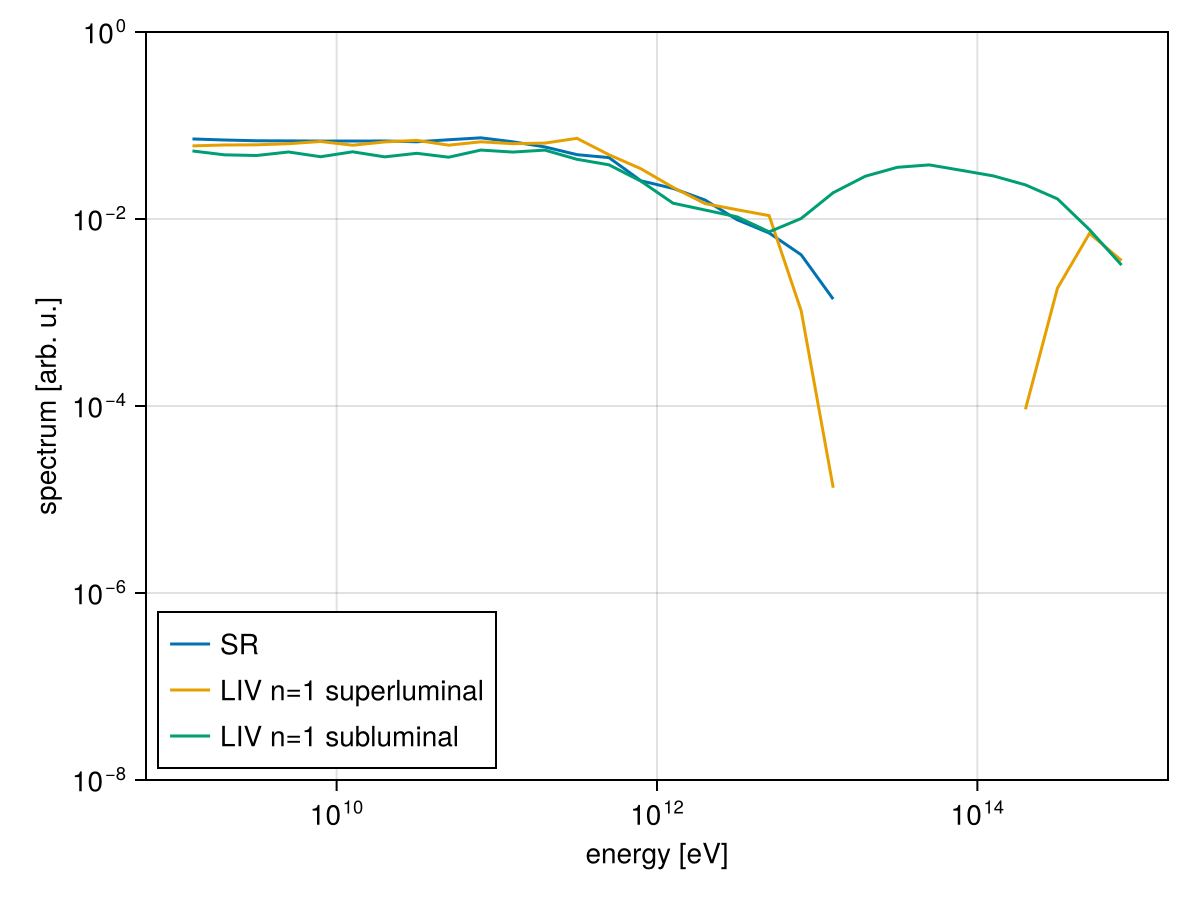

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1]; xlabel = "energy [eV]", ylabel = "spectrum [arb. u.]", xscale = log10, yscale = log10)
ylims!(ax, 1e-8, 1.)
lines!(ax, binCentresE, ySR; label = "SR")
lines!(ax, binCentresE, yLIV2p; label = "LIV n=1 superluminal")
lines!(ax, binCentresE, yLIV2m; label = "LIV n=1 subluminal")
axislegend(ax; position = :lb)

fig
